___
### Using binning data constructed from notebook 5 to run the models below: 
- Logistic Regression: 10 versions, in which we tried different subsets : drop or add in featutes
- Random Forest: Tried 2 versions

Goal: Modell that use at least features as possible; however, still can generalize at the same time.
___

### Import Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from plotly import tools
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

import datetime, warnings, scipy 
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from collections import Counter
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import lightgbm

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import brier_score_loss

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set standard parameters
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
!ls "/content/drive/My Drive"

___
### Create functions for modeling
___

In [0]:
# Function to run model
def fit_predict_score(Model, X_train, y_train, X_test, y_test,threshold):
  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Model.fit(X_train, y_train)
    
    '''Print out Test Results'''
    y_pred_test = Model.predict_proba(X_test)[:,1]
    sns.distplot(y_pred_test)
    plt.show()
    print('Best Threshold Percentile:',np.percentile(y_pred_test, 90, axis=0))
    print('ROC_AUC: ',roc_auc_score(y_true=y_test,y_score=y_pred_test))
    print('Brier_Score: ',brier_score_loss(y_test,y_pred_test))

    '''Print out Train Results'''
    for i in range(0,len(y_pred_test)):
      if y_pred_test[i]>= threshold:
        y_pred_test[i]=1
      else:
        y_pred_test[i]=0
    print("Accuracy Score_Test:", round(metrics.accuracy_score(y_test, y_pred_test),3))
    print("Classification Report_Test:\n",metrics.classification_report(y_test,y_pred_test))
    df_label_names = [0,1]
    confusion_matrix_test =  metrics.confusion_matrix(y_test, y_pred_test.ravel())
    sns.heatmap(confusion_matrix_test, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=df_label_names, yticklabels=df_label_names, annot=True, fmt='d')
    plt.title("Classification Matrix_Test", fontsize = 15)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    '''Print out Train Results'''
    y_pred_train = Model.predict_proba(X_train)[:,1]
    sns.distplot(y_pred_train)
    plt.show()
    print('ROC_AUC: ', roc_auc_score(y_true=y_train,y_score=y_pred_train))
    print('Brier_Score: ',brier_score_loss(y_train,y_pred_train))
    '''Print out Train Results'''
    for i in range(0,len(y_pred_train)):
      if y_pred_train[i]>= threshold:
        y_pred_train[i]=1
      else:
        y_pred_train[i]=0 

    print("Accuracy Score_Train:", round(metrics.accuracy_score(y_train, y_pred_train),3))
    print("Classification Report_Train:\n",metrics.classification_report(y_train,y_pred_train))
    

    confusion_matrix_train =  metrics.confusion_matrix(y_train, y_pred_train.ravel())
    sns.heatmap(confusion_matrix_train, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=df_label_names, yticklabels=df_label_names, annot=True, fmt='d')
    plt.title("Classification Matrix_Train", fontsize = 15)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
#for Model in Models:
  

In [0]:
from sklearn.model_selection import cross_val_score

def print_accuracy_report(Model, X, y, num_validations=5):
    accuracy = cross_val_score(Model, 
            X, y, scoring='accuracy', cv=num_validations)
    print("Accuracy_CV:", accuracy)
    print("Accuracy_Mean: " + str(round(100*accuracy.mean(), 2)) + "%")

    f1 = cross_val_score(Model, 
            X, y, scoring='f1_weighted', cv=num_validations)
    print("F1_CV:", f1)
    print("F1_Mean: " + str(round(100*f1.mean(), 2)) + "%")

    precision = cross_val_score(Model, 
            X, y, scoring='precision_weighted', cv=num_validations)
    print("Precision_CV:", precision)
    print("Precision_Mean: " + str(round(100*precision.mean(), 2)) + "%")

    recall = cross_val_score(Model, 
            X, y, scoring='recall_weighted', cv=num_validations)
    print("Recall_CV:", recall)
    print("Recall_Mean: " + str(round(100*recall.mean(), 2)) + "%")

In [0]:
random_state = 233
LR = LogisticRegression(random_state = random_state)

In [0]:
# def show_feature_importance(model,col):
#   df = pd.DataFrame(pd.Series(np.round(model.feature_importances_*100,4), index=cols))
#   #df.rename(columns = {0:'Value'})
#   df.sort_values(by =0,ascending=False,inplace = True)
#   df['cumpercent']=np.round(df[0].cumsum()/df[0].sum()*100,4)
#   return df

In [0]:
def create_subset(model_importance,percent):
  # define column of subset
  cut_fea = model_importance[model_importance['cumpercent']< percent].index.tolist()
  cut_fea.append('hospital_death')

  #put in a subset
  df_sub = df_model[cut_fea]
  cut_fea.remove('hospital_death')

  #define categorial columns and continuous columns
  dummies_col_sub =[]
  columns_continuous =[]
  for i in cut_fea:
    if i in dummies_col:
      dummies_col_sub.append(i)
    else:
      columns_continuous.append(i)
  return df_sub,dummies_col_sub,columns_continuous

In [0]:
def split_normalize(data,dummines_col,columns_contiuous):
  #train split dataset
  from sklearn.model_selection import train_test_split

  X = data.drop(['hospital_death'],axis=1)
  y = data['hospital_death']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=911)

  #split train_test dataset
  from sklearn.preprocessing import StandardScaler, OneHotEncoder

  # Instantiate encoder/scaler
  scaler = StandardScaler()

  # Scale and Encode Separate Columns
  #fit
  scaler.fit(X_train[columns_contiuous])

  #transform

  train_scaled_columns=scaler.transform(X_train[columns_contiuous]) 
  test_scaled_columns=scaler.transform(X_test[columns_contiuous]) 

  # Concatenate (Column-Bind) Processed Columns Back Together
  train_processed_data = np.concatenate([train_scaled_columns, X_train[dummines_col].values], axis=1)
  test_processed_data = np.concatenate([test_scaled_columns, X_test[dummines_col].values], axis=1)
  return train_processed_data,test_processed_data,y_train,y_test

___
### Partial Bining
Convert some of variables that shows importantance back into continous variables
- 'age','bmi','height','weight','pre_icu_los_days'  (convert to continous)
- Add in some min, max difference between first hour and first day


In [0]:
df = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_data.csv')
df.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]","(-117.0, -23.0]","(20.0, 92.0]","(4.0, 8.0]","(4.0, 9.0]","(-60.0, -7.0]","(99.0, 100.0]","(-1.0, 89.0]","

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df[i]=df[i].astype('object')

In [0]:
columns_to_encode =[i for i in df.columns if df[i].dtype == 'O']
columns_to_scale =['age','bmi','height','weight','pre_icu_los_days']

In [0]:
df_model=df.copy()
df_model.drop('apache_3j_diagnosis',axis=1,inplace=True)

In [0]:
dummies =pd.get_dummies(df_model[columns_to_encode])
dummies_col =[i for i in dummies.columns]

df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

X = df_model.drop(['hospital_death','patient_id'],axis=1)
y = df_model['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=911)

In [0]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
#fit
scaler.fit(X_train[columns_to_scale])

#transform

train_scaled_columns=scaler.transform(X_train[columns_to_scale]) 
test_scaled_columns=scaler.transform(X_test[columns_to_scale]) 

# Concatenate (Column-Bind) Processed Columns Back Together
train_processed_data = np.concatenate([train_scaled_columns, X_train[dummies_col].values], axis=1)
test_processed_data = np.concatenate([test_scaled_columns, X_test[dummies_col].values], axis=1)

___
### I.Logistic Regression


___
#### 1.WITHOUT SMOTE

___

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


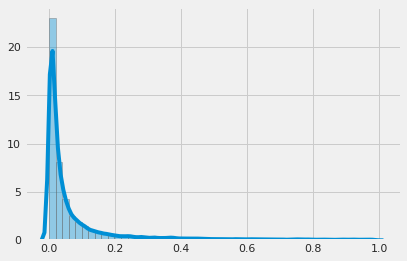

ROC_AUC:  0.8829942317966332
Brier_Score:  0.0571302837125455
Accuracy Score_Test: 0.926
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.65      0.30      0.41      1979

    accuracy                           0.93     22929
   macro avg       0.79      0.64      0.69     22929
weighted avg       0.91      0.93      0.91     22929



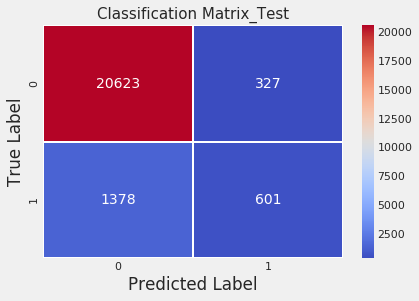

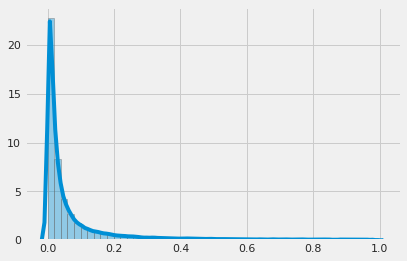

0.8976256457414389
Accuracy Score_Train: 0.929
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.69      0.33      0.44      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.66      0.70     68784
weighted avg       0.92      0.93      0.92     68784



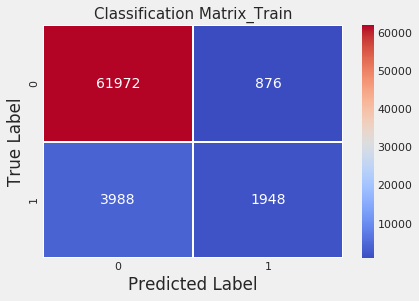

In [0]:
fit_predict_score(LR, train_processed_data, y_train, test_processed_data, y_test,threshold=0.5)

In [0]:
print_accuracy_report(LR, X_train, y_train, num_validations=3)

Accuracy_CV: [0.92725052 0.92480809 0.92559316]
Accuracy_Mean: 92.59%
F1_CV: [0.9144054  0.9113345  0.91381917]
F1_Mean: 91.32%
Precision_CV: [0.91475809 0.91085905 0.91253182]
Precision_Mean: 91.27%
Recall_CV: [0.92725052 0.92480809 0.92559316]
Recall_Mean: 92.59%


In [0]:
%precision 4
cols = columns_to_scale+dummies_col
feature_importances =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances.rename(columns={0: "Coefficient"},inplace=True)
feature_importances['Importance']=np.round(feature_importances['Coefficient']/feature_importances['Coefficient'].sum()*100,4)
feature_importances.sort_values('Importance',ascending=False,inplace=True)
feature_importances['cumsum']=feature_importances['Importance'].cumsum()
feature_importances

,Coefficient,Importance,cumsum
apache_3j_bodysystem_Metabolic,1.0,1.5,1.5
gcs_motor_apache_2.0,0.6,0.9,2.4
bin_d1_lactate_min_100_percentile,0.6,0.9,3.2
apache_3j_bodysystem_Neurological,0.5,0.8,4.0
gcs_motor_apache_6.0,0.5,0.8,4.8
...,...,...,...
bin_d1_lactate_max_60_percentile,0.0,0.0,100.0
"bin_d1_h1_min_arterial_ph_(0.0, 0.6]",0.0,0.0,100.0
"bin_d1_h1_min_glucose_(-58.0, -21.0]",0.0,0.0,100.0
bin_heart_rate_apache_20_percentile,0.0,0.0,100.0


___
#### 2.WITH SMOTE
- After over sampling the datase, the dataset increase the recall for death, lower precison 
___

In [0]:
from imblearn.over_sampling import SMOTE
# using SMOTE for unbalanced data
X_train_ns, y_train_ns= SMOTE().fit_resample(X_train, y_train)

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 17.4 µs


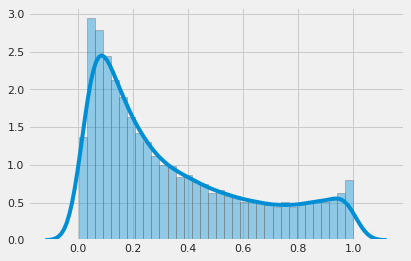

ROC_AUC:  0.864026912654471
Brier_Score:  0.15909049743887502
Accuracy Score_Test: 0.778
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.97      0.78      0.87     20950
           1       0.25      0.79      0.38      1979

    accuracy                           0.78     22929
   macro avg       0.61      0.78      0.62     22929
weighted avg       0.91      0.78      0.82     22929



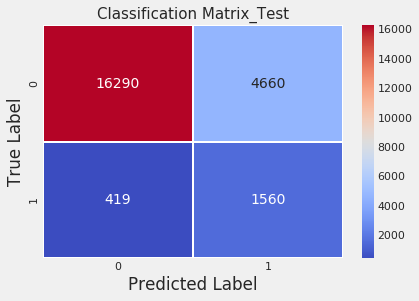

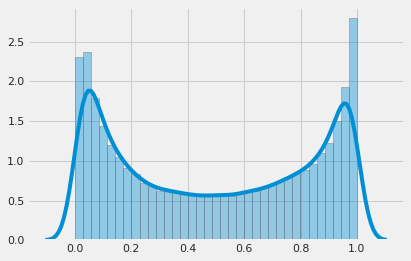

0.904644655462661
Accuracy Score_Train: 0.826
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     62848
           1       0.83      0.82      0.82     62848

    accuracy                           0.83    125696
   macro avg       0.83      0.83      0.83    125696
weighted avg       0.83      0.83      0.83    125696



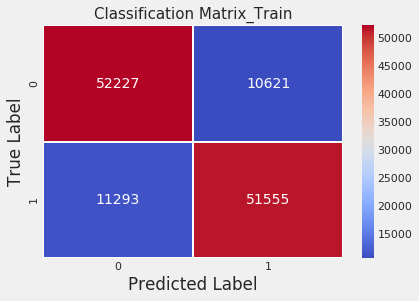

In [0]:
fit_predict_score(LR, X_train_ns, y_train_ns, test_processed_data, y_test,0.5)

#### 3.Hyper Parameter Tunning

In [0]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# LR_grid = LogisticRegression(random_state = random_state)
# param_grid = {'penalty' : ['l1', 'l2']}



# # Create gridsearch object with various combinations of parameters
# LR_Grid = RandomizedSearchCV(LR_grid, param_grid, cv = 5,
#                        scoring = 'roc_auc_ovr', refit = True,
#                        n_jobs=-1, verbose = 5)

In [0]:
# LR_Grid.fit(train_processed_data, y_train)

In [0]:
# lR_best = LR_grid.get_params
# lR_best

In [0]:
# fit_predict_score(LR_grid, train_processed_data, y_train, test_processed_data, y_test,0.3)

In [0]:
# %precision 4
# cols = columns_to_scale+dummies_col
# feature_importances_lrG =pd.DataFrame(data=abs(LR_grid.coef_.transpose()),index=cols)
# feature_importances_lrG.rename(columns={0: "Coefficient"},inplace=True)
# feature_importances_lrG['Importance']=np.round(feature_importances_lrG['Coefficient']/feature_importances_lrG['Coefficient'].sum()*100,4)
# feature_importances_lrG.sort_values('Importance',ascending=False,inplace=True)
# feature_importances_lrG['cumsum']=feature_importances_lrG['Importance'].cumsum()
# feature_importances_lrG

___
#### 4.Remove all 20 percentile bin
___

In [0]:
df = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_data.csv')
df.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]","(-117.0, -23.0]","(20.0, 92.0]","(4.0, 8.0]","(4.0, 9.0]","(-60.0, -7.0]","(99.0, 100.0]","(-1.0, 89.0]","

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df[i]=df[i].astype('object')

In [0]:
columns_to_scale =['age','bmi','height','weight','pre_icu_los_days']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df.copy()
df_model.drop(['apache_3j_diagnosis'],axis=1,inplace=True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df[i].dtype == 'O']
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]
dummies.drop(dummies_to_drop,axis=1,inplace=True)
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)

In [0]:
#split train and test
train_processed_data_pulse,test_processed_data_pulse,y_train,y_test=split_normalize(df_model,dummies_col,columns_to_scale)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


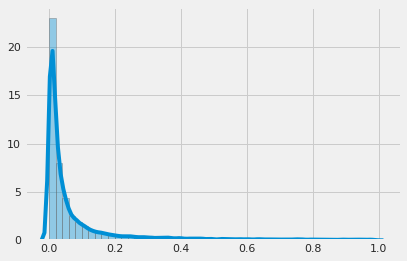

ROC_AUC:  0.8828672661996309
Brier_Score:  0.05719292835011699
Accuracy Score_Test: 0.926
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.65      0.30      0.41      1979

    accuracy                           0.93     22929
   macro avg       0.79      0.64      0.69     22929
weighted avg       0.91      0.93      0.91     22929



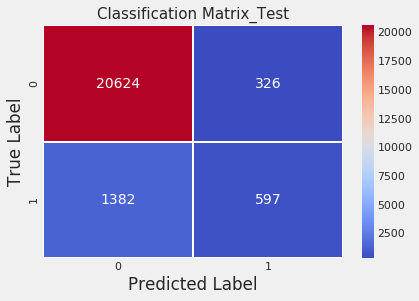

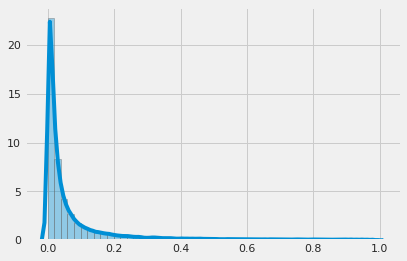

0.8976864929281309
Accuracy Score_Train: 0.929
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.69      0.33      0.44      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.66      0.70     68784
weighted avg       0.92      0.93      0.92     68784



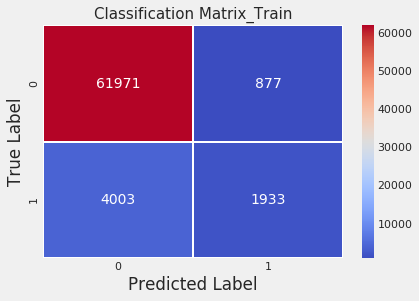

In [0]:
fit_predict_score(LR, train_processed_data_pulse, y_train, test_processed_data_pulse, y_test,threshold=0.5)

In [0]:
cols = dummies_col+columns_to_scale
feature_importances_lr =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances_lr.rename(columns={0: "Coefficient"},inplace=True)
feature_importances_lr['Importance']=np.round(feature_importances_lr['Coefficient']/feature_importances_lr['Coefficient'].sum()*100,4)
feature_importances_lr.sort_values('Importance',ascending=False,inplace=True)
feature_importances_lr['cumsum']=feature_importances_lr['Importance'].cumsum()
feature_importances_lr.head(300)

,Coefficient,Importance,cumsum
apache_3j_bodysystem_Trauma,1.0,1.2,1.2
bin_d1_platelets_max_100_percentile,1.0,1.2,2.4
ethnicity_Native American,0.7,0.8,3.3
bin_d1_heartrate_min_100_percentile,0.6,0.7,4.0
"bin_d1_h1_min_bun_(-109.0, -3.0]",0.6,0.7,4.7
bin_d1_h1_max_hco3_Normal,0.6,0.7,5.4
gcs_unable_apache_0.0,0.6,0.7,6.1
bmi_35_0,0.5,0.7,6.8
bin_d1_hemaglobin_min_80_percentile,0.5,0.7,7.5
bin_d1_inr_min_100_percentile,0.5,0.7,8.1


In [0]:
len(feature_importances_lr)

613

___
#### 5.Remove all apache bin
___

In [0]:
df = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_data.csv')
df.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]","(-117.0, -23.0]","(20.0, 92.0]","(4.0, 8.0]","(4.0, 9.0]","(-60.0, -7.0]","(99.0, 100.0]","(-1.0, 89.0]","

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df[i]=df[i].astype('object')

In [0]:
columns_to_scale =['age','bmi','height','weight','pre_icu_los_days']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df.copy()
df_model.drop(['apache_3j_diagnosis'],axis=1,inplace=True)

In [0]:
#drop all apache score
# columns_to_drop_apache =  [i for i in df_model.columns if (i.lower()[:3]=='bin') & ("apache" in i)]

df_model.drop(['bin_albumin_apache',
 'bin_bilirubin_apache',
 'bin_bun_apache',
 'bin_creatinine_apache',
 'bin_glucose_apache',
 'bin_sodium_apache',
 'bin_wbc_apache',
 'bin_paco2_apache',
 'bin_pao2_apache',
 'bin_ph_apache',
 'bin_heart_rate_apache',
 'bin_temp_apache'], axis =1, inplace = True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df[i].dtype == 'O']
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]
dummies.drop(dummies_to_drop,axis=1,inplace=True)

# drop bmi_35_1, elective_surgery_1
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)

In [0]:
#split train and test
train_processed_data_pulse,test_processed_data_pulse,y_train,y_test=split_normalize(df_model,dummies_col,columns_to_scale)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


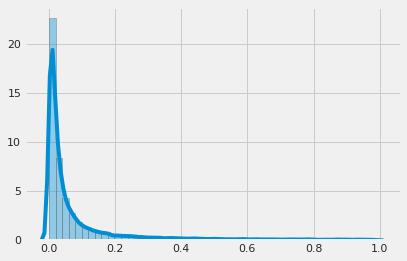

ROC_AUC:  0.8807080792232522
Brier_Score:  0.057389015369348935
Accuracy Score_Test: 0.925
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.64      0.30      0.41      1979

    accuracy                           0.92     22929
   macro avg       0.79      0.64      0.68     22929
weighted avg       0.91      0.92      0.91     22929



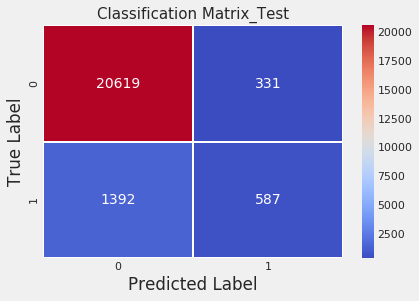

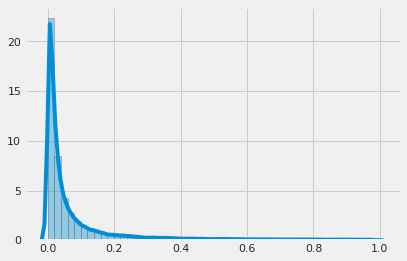

0.895287256190952
Accuracy Score_Train: 0.928
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.68      0.32      0.44      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.65      0.70     68784
weighted avg       0.92      0.93      0.92     68784



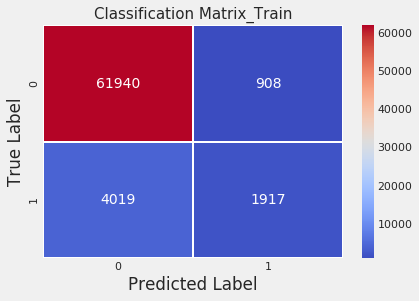

In [0]:
fit_predict_score(LR, train_processed_data_pulse, y_train, test_processed_data_pulse, y_test,threshold=0.5)

In [0]:
cols = dummies_col+columns_to_scale
feature_importances_lr =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances_lr.rename(columns={0: "Coefficient"},inplace=True)
feature_importances_lr['Importance']=np.round(feature_importances_lr['Coefficient']/feature_importances_lr['Coefficient'].sum()*100,4)
feature_importances_lr.sort_values('Importance',ascending=False,inplace=True)
feature_importances_lr['cumsum']=feature_importances_lr['Importance'].cumsum()
feature_importances_lr.head(300)

,Coefficient,Importance,cumsum
apache_3j_bodysystem_Trauma,1.0,1.4,1.4
bin_d1_platelets_max_100_percentile,1.0,1.4,2.7
bin_d1_heartrate_min_100_percentile,0.7,1.0,3.7
ethnicity_Native American,0.7,0.9,4.6
bin_d1_creatinine_min_100_percentile,0.6,0.8,5.5
gcs_unable_apache_0.0,0.6,0.8,6.3
bin_d1_inr_min_100_percentile,0.5,0.7,7.0
bin_d1_hemaglobin_min_80_percentile,0.5,0.7,7.7
elective_surgery_0,0.5,0.7,8.4
bin_d1_temp_min_60_percentile,0.5,0.7,9.1


In [0]:
len(feature_importances_lr)

553

___
#### 6.Remove race and gender
___

In [0]:
df = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_data.csv')
df.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]","(-117.0, -23.0]","(20.0, 92.0]","(4.0, 8.0]","(4.0, 9.0]","(-60.0, -7.0]","(99.0, 100.0]","(-1.0, 89.0]","

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df[i]=df[i].astype('object')

In [0]:
columns_to_scale =['age','bmi','height','weight','pre_icu_los_days']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df.copy()
df_model.drop(['apache_3j_diagnosis'],axis=1,inplace=True)

In [0]:
#drop all apache score
# columns_to_drop_apache =  [i for i in df_model.columns if (i.lower()[:3]=='bin') & ("apache" in i)]

df_model.drop(['bin_albumin_apache',
 'bin_bilirubin_apache',
 'bin_bun_apache',
 'bin_creatinine_apache',
 'bin_glucose_apache',
 'bin_sodium_apache',
 'bin_wbc_apache',
 'bin_paco2_apache',
 'bin_pao2_apache',
 'bin_ph_apache',
 'bin_heart_rate_apache',
 'bin_temp_apache'], axis =1, inplace = True)

In [0]:
df_model.drop(['gender','ethnicity'],axis=1,inplace=True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df[i].dtype == 'O']
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]
dummies.drop(dummies_to_drop,axis=1,inplace=True)
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)

In [0]:
#split train and test
train_processed_data_pulse,test_processed_data_pulse,y_train,y_test=split_normalize(df_model,dummies_col,columns_to_scale)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


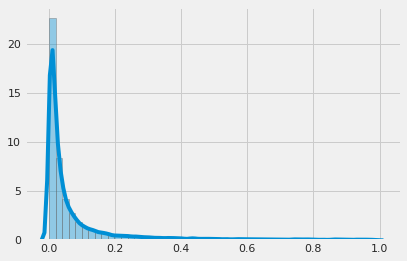

ROC_AUC:  0.8805622279760879
Brier_Score:  0.057463605007781964
Accuracy Score_Test: 0.925
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.64      0.29      0.40      1979

    accuracy                           0.92     22929
   macro avg       0.79      0.64      0.68     22929
weighted avg       0.91      0.92      0.91     22929



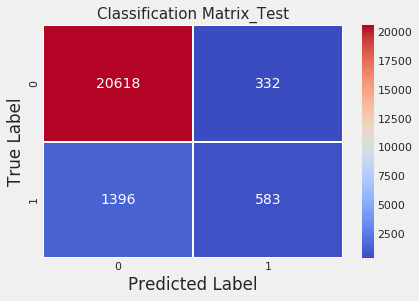

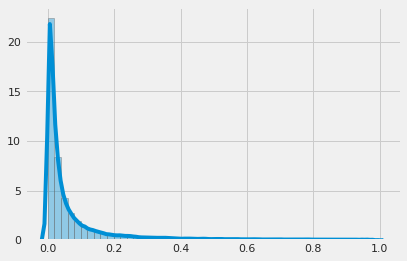

0.8951692903830609
Accuracy Score_Train: 0.929
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.68      0.32      0.44      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.65      0.70     68784
weighted avg       0.92      0.93      0.92     68784



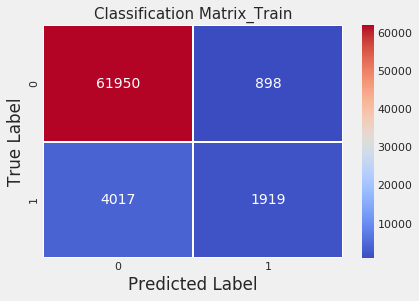

In [0]:
fit_predict_score(LR, train_processed_data_pulse, y_train, test_processed_data_pulse, y_test,threshold=0.5)

In [0]:
cols = dummies_col+columns_to_scale
feature_importances_lr =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances_lr.rename(columns={0: "Coefficient"},inplace=True)
feature_importances_lr['Importance']=np.round(feature_importances_lr['Coefficient']/feature_importances_lr['Coefficient'].sum()*100,4)
feature_importances_lr.sort_values('Importance',ascending=False,inplace=True)
feature_importances_lr['cumsum']=feature_importances_lr['Importance'].cumsum()
feature_importances_lr.head(300)

,Coefficient,Importance,cumsum
apache_3j_bodysystem_Trauma,1.0,1.4,1.4
bin_d1_platelets_max_100_percentile,1.0,1.4,2.8
hospital_admit_source_Floor,0.7,0.9,3.7
bin_d1_heartrate_min_100_percentile,0.7,0.9,4.7
bin_d1_creatinine_min_100_percentile,0.6,0.8,5.5
gcs_unable_apache_0.0,0.6,0.8,6.3
bin_d1_inr_min_100_percentile,0.5,0.7,7.0
elective_surgery_0,0.5,0.7,7.7
bin_d1_hemaglobin_min_80_percentile,0.5,0.7,8.5
bmi_35_0,0.5,0.7,9.1


___
#### 7.Add in pulse pressure,remove disbap, sysbp related measure
___

In [0]:
df_pulse = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_pulse_death.csv')
df_pulse.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,apache_4a_hospital_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,missing_count,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache,pulse_pressure_min,pulse_pressure_max,diff_pulse_max_min
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,60,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]"

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df_pulse[i]=df_pulse[i].astype('object')

In [0]:
columns_to_scale =['age','bmi','height','weight','pre_icu_los_days','pulse_pressure_min',	'pulse_pressure_max',	'diff_pulse_max_min']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df_pulse.copy()
df_model.drop(['apache_3j_diagnosis','apache_4a_hospital_death_prob'],axis=1,inplace=True)
df_model.drop(['gender','ethnicity'],axis=1,inplace=True)

In [0]:
df_model.drop(['bin_albumin_apache',
 'bin_bilirubin_apache',
 'bin_bun_apache',
 'bin_creatinine_apache',
 'bin_glucose_apache',
 'bin_sodium_apache',
 'bin_wbc_apache',
 'bin_paco2_apache',
 'bin_pao2_apache',
 'bin_ph_apache',
 'bin_heart_rate_apache',
 'bin_temp_apache'], axis =1, inplace = True)

In [0]:
columns_to_drop = [i for i in df_model.columns if (i.lower()[:3]=='bin') & (("sysbp" in i) |("diasbp" in i))]
df_model.drop(columns_to_drop,axis=1,inplace=True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df_pulse[i].dtype == 'O']
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]
dummies.drop(dummies_to_drop,axis=1,inplace=True)
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)

In [0]:
df_model.isnull().sum().sort_values(ascending = False)

pulse_pressure_min                                       165
diff_pulse_max_min                                       165
pulse_pressure_max                                       165
bin_d1_hemaglobin_min_Normal                             0  
bin_d1_hemaglobin_min_60_percentile                      0  
bin_d1_hemaglobin_min_40_percentile                      0  
bin_d1_hemaglobin_min_100_percentile                     0  
bin_d1_hemaglobin_max_Normal                             0  
bin_d1_hemaglobin_max_80_percentile                      0  
bin_fio2_apache_Normal                                   0  
bin_d1_hemaglobin_max_60_percentile                      0  
bin_d1_hemaglobin_max_40_percentile                      0  
bin_d1_hemaglobin_max_100_percentile                     0  
bin_d1_h1_max_hco3_Normal                                0  
bin_d1_h1_max_hco3_(2.0, 34.0]                           0  
bin_d1_h1_max_hco3_(0.0, 2.0]                            0  
bin_d1_h1_max_hco3_(-16.

In [0]:
df_model.fillna(0,inplace=True)

In [0]:
#split train and test
train_processed_data_pulse,test_processed_data_pulse,y_train,y_test=split_normalize(df_model,dummies_col,columns_to_scale)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


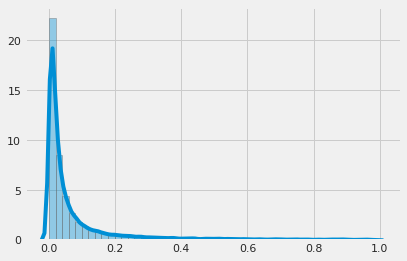

ROC_AUC:  0.8799497588642561
Brier_Score:  0.05749241082337461
Accuracy Score_Test: 0.926
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.65      0.30      0.41      1979

    accuracy                           0.93     22929
   macro avg       0.79      0.64      0.69     22929
weighted avg       0.91      0.93      0.91     22929



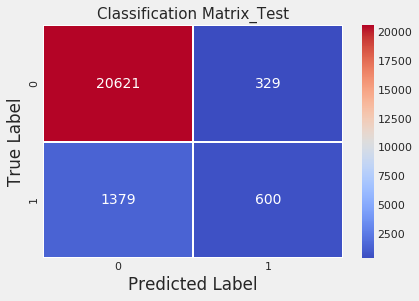

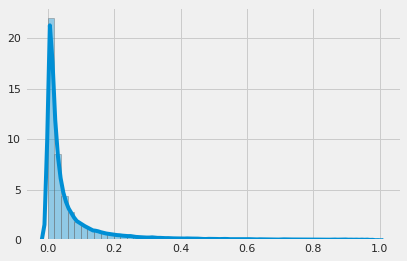

0.894222623419324
Accuracy Score_Train: 0.928
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.68      0.32      0.43      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.65      0.70     68784
weighted avg       0.92      0.93      0.92     68784



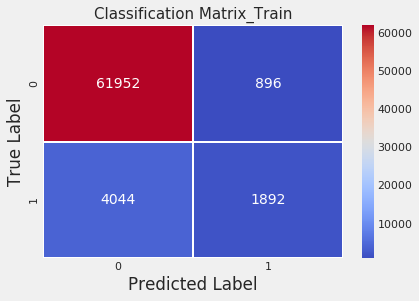

In [0]:
fit_predict_score(LR, train_processed_data_pulse, y_train, test_processed_data_pulse, y_test,threshold=0.5)

In [0]:
columns_to_scale

['age',
 'bmi',
 'height',
 'weight',
 'pre_icu_los_days',
 'pulse_pressure_min',
 'pulse_pressure_max',
 'diff_pulse_max_min']

In [0]:
cols = dummies_col+columns_to_scale
feature_importances_lr =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances_lr.rename(columns={0: "Coefficient"},inplace=True)
feature_importances_lr['Importance']=np.round(feature_importances_lr['Coefficient']/feature_importances_lr['Coefficient'].sum()*100,4)
feature_importances_lr.sort_values('Importance',ascending=False,inplace=True)
feature_importances_lr['cumsum']=feature_importances_lr['Importance'].cumsum()
feature_importances_lr.head(300)

,Coefficient,Importance,cumsum
"bin_d1_h1_min_bun_(-109.0, -3.0]",1.0,1.5,1.5
bin_d1_platelets_max_80_percentile,1.0,1.5,3.0
bin_d1_heartrate_min_80_percentile,0.7,1.0,4.0
hospital_admit_source_Observation,0.7,1.0,5.1
bin_d1_creatinine_min_80_percentile,0.6,0.9,6.0
gcs_verbal_apache_2.0,0.6,0.9,6.9
elective_surgery_0,0.5,0.8,7.6
bin_d1_inr_min_80_percentile,0.5,0.8,8.4
"bin_d1_max_min_temp_(-0.1, 0.5]",0.5,0.8,9.2
"bin_d1_h1_min_hemaglobin_(-1.3, -0.5]",0.5,0.8,9.9


In [0]:
feature_importances_lr[feature_importances_lr.index.isin(['pulse_pressure_min','pulse_pressure_max','diff_pulse_max_min'])]

,Coefficient,Importance,cumsum
pulse_pressure_max,0.2,0.3,53.8
pulse_pressure_min,0.1,0.2,80.2
diff_pulse_max_min,0.0,0.0,98.4


In [0]:
len(feature_importances)

681

___
#### 8.Adding missing feature counts
___

In [0]:
df_pulse = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_pulse_death.csv')
df_pulse.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,apache_4a_hospital_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,missing_count,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache,pulse_pressure_min,pulse_pressure_max,diff_pulse_max_min
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,60,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]"

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df_pulse[i]=df_pulse[i].astype('object')

In [0]:
columns_to_scale =['age','bmi','height','weight','pre_icu_los_days','missing_count','pulse_pressure_min',	'pulse_pressure_max',	'diff_pulse_max_min']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df_pulse.copy()
df_model.drop(['apache_3j_diagnosis','apache_4a_hospital_death_prob'],axis=1,inplace=True)
df_model.drop(['gender','ethnicity'],axis=1,inplace=True)

columns_to_drop = [i for i in df_model.columns if (i.lower()[:3]=='bin') & (("sysbp" in i) |("diasbp" in i))]
df_model.drop(columns_to_drop,axis=1,inplace=True)

In [0]:
df_model.drop(['bin_albumin_apache',
 'bin_bilirubin_apache',
 'bin_bun_apache',
 'bin_creatinine_apache',
 'bin_glucose_apache',
 'bin_sodium_apache',
 'bin_wbc_apache',
 'bin_paco2_apache',
 'bin_pao2_apache',
 'bin_ph_apache',
 'bin_heart_rate_apache',
 'bin_temp_apache'], axis =1, inplace = True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df_pulse[i].dtype == 'O']
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]
dummies.drop(dummies_to_drop,axis=1,inplace=True)
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model.isnull().sum().sort_values(ascending = False)

pulse_pressure_min                                       165
diff_pulse_max_min                                       165
pulse_pressure_max                                       165
bin_d1_hemaglobin_min_Normal                             0  
bin_d1_hemaglobin_min_60_percentile                      0  
bin_d1_hemaglobin_min_40_percentile                      0  
bin_d1_hemaglobin_min_100_percentile                     0  
bin_d1_hemaglobin_max_Normal                             0  
bin_d1_hemaglobin_max_80_percentile                      0  
bin_fio2_apache_Normal                                   0  
bin_d1_hemaglobin_max_60_percentile                      0  
bin_d1_hemaglobin_max_40_percentile                      0  
bin_d1_hemaglobin_max_100_percentile                     0  
bin_d1_h1_max_hco3_Normal                                0  
bin_d1_h1_max_hco3_(2.0, 34.0]                           0  
bin_d1_h1_max_hco3_(0.0, 2.0]                            0  
bin_d1_h1_max_hco3_(-16.

In [0]:
df_model.fillna(0,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

X = df_model.drop('hospital_death',axis=1)
y = df_model['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=911)


In [0]:
test_id =X_test['patient_id'].tolist()

In [0]:
X_train.drop('patient_id',axis=1,inplace=True)
X_test.drop('patient_id',axis=1,inplace=True)

In [0]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
#fit
scaler.fit(X_train[columns_to_scale])

#transform

train_scaled_columns=scaler.transform(X_train[columns_to_scale]) 
test_scaled_columns=scaler.transform(X_test[columns_to_scale]) 

# Concatenate (Column-Bind) Processed Columns Back Together
train_processed_data = np.concatenate([train_scaled_columns, X_train[dummies_col].values], axis=1)
test_processed_data = np.concatenate([test_scaled_columns, X_test[dummies_col].values], axis=1)

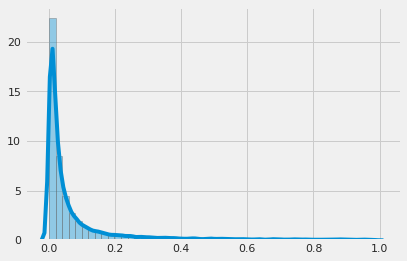

Best Threshold Percentile: 0.24225654316426815
ROC_AUC:  0.8800253979433212
Brier_Score:  0.057485506733684084
Accuracy Score_Test: 0.925
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.65      0.30      0.41      1979

    accuracy                           0.93     22929
   macro avg       0.79      0.64      0.68     22929
weighted avg       0.91      0.93      0.91     22929



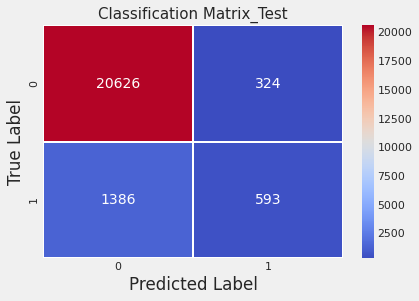

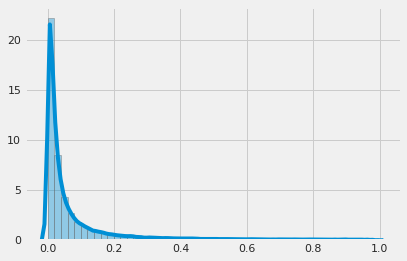

ROC_AUC:  0.8942505541543606
Brier_Score:  0.05489193462283774
Accuracy Score_Train: 0.928
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.68      0.32      0.43      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.65      0.70     68784
weighted avg       0.92      0.93      0.92     68784



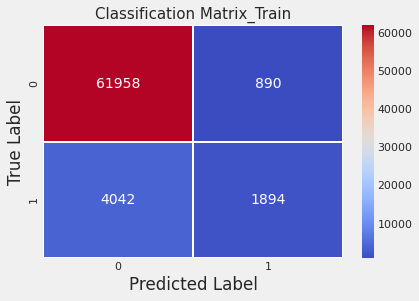

In [0]:
fit_predict_score(LR, train_processed_data, y_train, test_processed_data, y_test,threshold=0.5)

In [0]:
cols = columns_to_scale+dummies_col
feature_importances =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances.rename(columns={0: "Coefficient"},inplace=True)
feature_importances['Importance']=np.round(feature_importances['Coefficient']/feature_importances['Coefficient'].sum()*100,4)
feature_importances.sort_values('Importance',ascending=False,inplace=True)
feature_importances['cumpercent']=feature_importances['Importance'].cumsum()
feature_importances.head(100)

,Coefficient,Importance,cumpercent
apache_3j_bodysystem_Metabolic,1.0,1.5,1.5
bin_d1_lactate_min_100_percentile,1.0,1.5,3.0
elective_surgery_0,0.7,1.0,4.0
bin_d1_heartrate_max_100_percentile,0.7,1.0,5.0
bin_d1_creatinine_max_100_percentile,0.6,0.9,5.9
gcs_motor_apache_2.0,0.6,0.8,6.8
bin_d1_inr_max_100_percentile,0.5,0.8,7.6
age,0.5,0.8,8.3
bin_d1_hemaglobin_max_80_percentile,0.5,0.8,9.1
apache_3j_bodysystem_Neurological,0.5,0.7,9.8


In [0]:
feature_importances[feature_importances.index.isin(['pulse_pressure_min','pulse_pressure_max','diff_pulse_max_min','missing_count','bmi_35_0','bmi'])]

,Coefficient,Importance,cumpercent
bmi_35_0,0.2,0.2,70.4
missing_count,0.1,0.2,73.0
pulse_pressure_min,0.1,0.1,90.3
pulse_pressure_max,0.0,0.1,96.7
diff_pulse_max_min,0.0,0.0,99.3
bmi,0.0,0.0,99.7


In [0]:
feature_importances.tail(100)

,Coefficient,Importance,cumpercent
bin_d1_h1_max_heartrate_Normal,0.0,0.0,97.9
bin_h1_max_min_heartrate_Normal,0.0,0.0,97.9
"bin_d1_h1_min_glucose_(-638.0, -58.0]",0.0,0.0,98.0
"bin_d1_max_min_spo2_(4.0, 7.0]",0.0,0.0,98.0
"bin_d1_h1_min_pco2_(0.0, 71.0]",0.0,0.0,98.0
"bin_d1_h1_max_pao2fio2ratio_(-1.0, 75.0]",0.0,0.0,98.1
"bin_d1_h1_max_heartrate_(0.0, 7.0]",0.0,0.0,98.1
"bin_d1_h1_max_spo2_(2.0, 100.0]",0.0,0.0,98.2
intubated_apache_0.0,0.0,0.0,98.2
bin_d1_inr_min_40_percentile,0.0,0.0,98.2


In [0]:
len(feature_importances)

492

___
#### 9.Drop bmi, importance that is greater than 99.9
___

In [0]:
columns_importance_drop1 =feature_importances[feature_importances.cumpercent>99.9].index.tolist()
columns_importance_drop1

['bin_d1_h1_min_temp_Normal',
 'bin_d1_h1_max_glucose_(9.0, 43.0]',
 'bin_d1_max_min_wbc_(-1.0, 1.0]',
 'bin_d1_h1_min_platelets_(-28.0, -5.0]',
 'bin_d1_h1_max_resprate_Normal',
 'bin_h1_max_min_resprate_Normal',
 'bin_d1_h1_min_resprate_Normal',
 'bin_h1_max_min_spo2_(1.0, 4.0]',
 'bin_d1_h1_max_resprate_(-98.0, 0.0]',
 'bin_d1_h1_max_platelets_(6.0, 230.0]',
 'bin_d1_h1_min_glucose_(0.0, 90.0]',
 'arf_apache_1.0',
 'bin_h1_max_min_resprate_(-1.0, 4.0]',
 'bin_d1_h1_min_glucose_Normal',
 'bin_d1_h1_max_glucose_Normal',
 'bin_d1_h1_min_arterial_ph_(0.0, 0.6]',
 'bin_d1_max_min_heartrate_(41.0, 177.0]',
 'bin_h1_max_min_mbp_(0.0, 8.0]',
 'hepatic_failure_1.0']

In [0]:
df_pulse = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_pulse_death.csv')
df_pulse.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,apache_4a_hospital_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,missing_count,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache,pulse_pressure_min,pulse_pressure_max,diff_pulse_max_min
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,60,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]"

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df_pulse[i]=df_pulse[i].astype('object')

In [0]:
columns_to_scale =['age','height','weight','pre_icu_los_days','missing_count','pulse_pressure_min',	'pulse_pressure_max',	'diff_pulse_max_min']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df_pulse.copy()
df_model.drop(['apache_3j_diagnosis','apache_4a_hospital_death_prob'],axis=1,inplace=True)

In [0]:
df_model.drop(['gender','ethnicity'],axis=1,inplace=True)

In [0]:
columns_to_drop = [i for i in df_model.columns if (i.lower()[:3]=='bin') & (("sysbp" in i) |("diasbp" in i))]

In [0]:
df_model.drop(columns_to_drop,axis=1,inplace=True)

In [0]:
df_model.drop(['bin_albumin_apache',
 'bin_bilirubin_apache',
 'bin_bun_apache',
 'bin_creatinine_apache',
 'bin_glucose_apache',
 'bin_sodium_apache',
 'bin_wbc_apache',
 'bin_paco2_apache',
 'bin_pao2_apache',
 'bin_ph_apache',
 'bin_heart_rate_apache',
 'bin_temp_apache'], axis =1, inplace = True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df_pulse[i].dtype == 'O' ]

In [0]:
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]

In [0]:
dummies.drop(dummies_to_drop,axis=1,inplace=True)

In [0]:
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)

In [0]:
dummies.drop(columns_importance_drop1,axis=1,inplace=True)

In [0]:
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)

In [0]:
dummies_col =[i for i in dummies.columns]

In [0]:
df_model.isnull().sum().sort_values(ascending = False)

pulse_pressure_min                                       165
diff_pulse_max_min                                       165
pulse_pressure_max                                       165
bin_fio2_apache_Normal                                   0  
bin_d1_hemaglobin_min_100_percentile                     0  
bin_d1_hemaglobin_max_Normal                             0  
bin_d1_hemaglobin_max_80_percentile                      0  
bin_d1_hemaglobin_max_60_percentile                      0  
bin_d1_hemaglobin_max_40_percentile                      0  
bin_d1_hemaglobin_min_60_percentile                      0  
bin_d1_hemaglobin_max_100_percentile                     0  
bin_d1_h1_max_hco3_Normal                                0  
bin_d1_h1_max_hco3_(2.0, 34.0]                           0  
bin_d1_h1_max_hco3_(0.0, 2.0]                            0  
bin_d1_h1_max_hco3_(-16.0, 0.0]                          0  
bin_d1_h1_min_hco3_Normal                                0  
bin_d1_hemaglobin_min_40

In [0]:
df_model.fillna(0,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

X = df_model.drop(['hospital_death','patient_id'],axis=1)
y = df_model['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=911)

In [0]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
#fit
scaler.fit(X_train[columns_to_scale])

#transform

train_scaled_columns=scaler.transform(X_train[columns_to_scale]) 
test_scaled_columns=scaler.transform(X_test[columns_to_scale]) 

# Concatenate (Column-Bind) Processed Columns Back Together
train_processed_data = np.concatenate([train_scaled_columns, X_train[dummies_col].values], axis=1)
test_processed_data = np.concatenate([test_scaled_columns, X_test[dummies_col].values], axis=1)

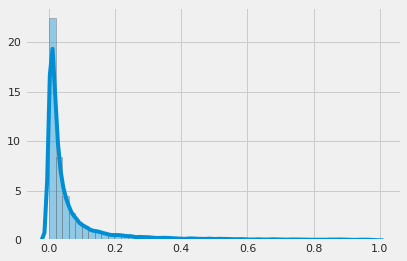

Best Threshold Percentile: 0.24137915342339983
ROC_AUC:  0.8800674142940011
Brier_Score:  0.057490155574346495
Accuracy Score_Test: 0.926
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.65      0.30      0.41      1979

    accuracy                           0.93     22929
   macro avg       0.79      0.64      0.69     22929
weighted avg       0.91      0.93      0.91     22929



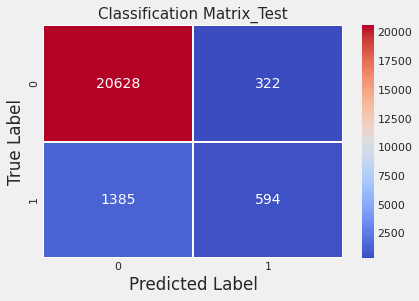

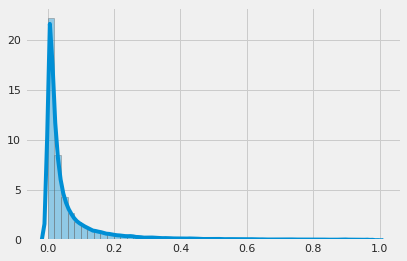

ROC_AUC:  0.8942721857313036
Brier_Score:  0.05489183158898943
Accuracy Score_Train: 0.928
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.68      0.32      0.43      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.65      0.70     68784
weighted avg       0.92      0.93      0.92     68784



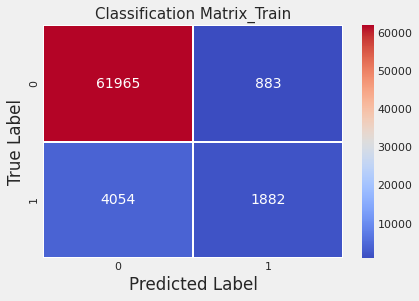

In [0]:
fit_predict_score(LR, train_processed_data, y_train, test_processed_data, y_test,threshold=0.5)

In [0]:
cols = columns_to_scale+dummies_col
feature_importances =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances.rename(columns={0: "Coefficient"},inplace=True)
feature_importances['Importance']=np.round(feature_importances['Coefficient']/feature_importances['Coefficient'].sum()*100,4)
feature_importances.sort_values('Importance',ascending=False,inplace=True)
feature_importances['cumpercent']=feature_importances['Importance'].cumsum()
feature_importances.head(100)

,Coefficient,Importance,cumpercent
apache_3j_bodysystem_Metabolic,1.0,1.5,1.5
bin_d1_lactate_min_100_percentile,1.0,1.5,3.0
elective_surgery_0,0.7,1.0,4.0
bin_d1_creatinine_max_100_percentile,0.7,1.0,4.9
bin_d1_heartrate_max_100_percentile,0.6,0.9,5.9
gcs_motor_apache_2.0,0.6,0.8,6.7
bin_d1_inr_max_100_percentile,0.6,0.8,7.5
bin_d1_hemaglobin_max_80_percentile,0.5,0.8,8.3
age,0.5,0.8,9.1
"bin_d1_h1_max_sodium_(0.0, 39.0]",0.5,0.7,9.8


In [0]:
feature_importances[feature_importances.index.isin(['pulse_pressure_min','pulse_pressure_max','diff_pulse_max_min','missing_count','bmi_35_0'])]

,Coefficient,Importance,cumpercent
bmi_35_0,0.2,0.2,70.6
missing_count,0.1,0.2,73.3
pulse_pressure_min,0.1,0.1,90.8
pulse_pressure_max,0.0,0.1,96.5
diff_pulse_max_min,0.0,0.0,99.6


In [0]:
feature_importances.tail(100)

,Coefficient,Importance,cumpercent
"bin_d1_h1_max_arterial_ph_(-0.30000000000000004, 0.0]",0.0,0.1,97.0
"bin_d1_max_min_mbp_(37.0, 52.0]",0.0,0.1,97.1
"bin_fio2_apache_(0.4, 0.5]",0.0,0.1,97.1
bin_d1_glucose_max_Normal,0.0,0.1,97.2
bin_d1_glucose_min_Normal,0.0,0.1,97.2
bin_d1_h1_min_platelets_Normal,0.0,0.1,97.3
bin_d1_h1_max_platelets_Normal,0.0,0.1,97.3
"bin_d1_h1_min_pao2fio2ratio_(-581.0, -21.0]",0.0,0.1,97.4
bin_d1_hco3_min_100_percentile,0.0,0.1,97.4
"bin_d1_max_min_po2_(-1.0, 17.0]",0.0,0.0,97.5


In [0]:
len(feature_importances)

472

___
#### 10.Drop importance that is greater than 99.9
___

In [0]:
columns_importance_drop =feature_importances[feature_importances.cumpercent>99.9].index.tolist()
columns_importance_drop

['bin_h1_max_min_mbp_Normal',
 'bin_d1_h1_min_mbp_Normal',
 'bin_d1_h1_min_arterial_ph_(-0.02, 0.0]',
 'bin_d1_max_min_spo2_(7.0, 10.0]',
 'bin_d1_h1_max_heartrate_(7.0, 17.0]',
 'bin_d1_hematocrit_max_60_percentile',
 'bin_d1_h1_min_glucose_(-58.0, -21.0]',
 'bin_d1_h1_max_spo2_(-98.0, 0.0]',
 'bin_d1_heartrate_max_Normal',
 'bin_d1_max_min_heartrate_Normal',
 'bin_d1_heartrate_min_Normal',
 'hepatic_failure_0.0',
 'bin_d1_hematocrit_max_40_percentile']

In [0]:
df_pulse = pd.read_csv('/content/drive/My Drive/Healthcare/Data/For_Modeling/partial_binning_pulse_death.csv')
df_pulse.head()

,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,apache_4a_hospital_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,missing_count,bmi_35,bin_albumin_apache,bin_bilirubin_apache,bin_bun_apache,bin_d1_h1_min_bun,bin_d1_h1_max_bun,bin_d1_calcium_max,bin_d1_calcium_min,bin_d1_creatinine_max,bin_d1_creatinine_min,bin_creatinine_apache,bin_d1_glucose_max,bin_d1_glucose_min,bin_glucose_apache,bin_d1_h1_min_glucose,bin_d1_h1_max_glucose,bin_d1_hco3_max,bin_d1_hco3_min,bin_d1_h1_min_hco3,bin_d1_h1_max_hco3,bin_d1_hemaglobin_max,bin_d1_hemaglobin_min,bin_d1_h1_min_hemaglobin,bin_d1_h1_max_hemaglobin,bin_d1_hematocrit_max,bin_d1_hematocrit_min,bin_d1_h1_min_hematocrit,bin_d1_inr_max,bin_d1_inr_min,bin_d1_lactate_max,bin_d1_lactate_min,bin_d1_platelets_max,bin_d1_platelets_min,bin_d1_h1_min_platelets,bin_d1_h1_max_platelets,bin_d1_sodium_max,bin_d1_sodium_min,bin_sodium_apache,bin_d1_h1_max_sodium,bin_d1_wbc_max,bin_d1_wbc_min,bin_wbc_apache,bin_d1_max_min_wbc,bin_d1_h1_min_wbc,bin_d1_arterial_pco2_max,bin_d1_arterial_pco2_min,bin_paco2_apache,bin_d1_max_min_pco2,bin_d1_h1_min_pco2,bin_d1_h1_max_pco2,bin_d1_arterial_po2_max,bin_d1_arterial_po2_min,bin_pao2_apache,bin_d1_max_min_po2,bin_d1_h1_min_po2,bin_d1_h1_max_po2,bin_d1_pao2fio2ratio_max,bin_d1_pao2fio2ratio_min,bin_d1_max_min_pao2fio2ratio,bin_h1_max_min_pao2fio2ratio,bin_d1_h1_min_pao2fio2ratio,bin_d1_h1_max_pao2fio2ratio,bin_d1_arterial_ph_max,bin_d1_arterial_ph_min,bin_ph_apache,bin_d1_max_min_arterial_ph,bin_d1_h1_max_arterial_ph,bin_d1_h1_min_arterial_ph,bin_d1_diasbp_max,bin_d1_diasbp_min,bin_d1_max_min_diasbp,bin_h1_max_min_diasbp,bin_d1_h1_max_diasbp,bin_d1_h1_min_diasbp,bin_d1_sysbp_max,bin_d1_sysbp_min,bin_d1_max_min_sysbp,bin_h1_max_min_sysbp,bin_d1_h1_max_sysbp,bin_d1_h1_min_sysbp,bin_d1_heartrate_max,bin_d1_heartrate_min,bin_heart_rate_apache,bin_d1_max_min_heartrate,bin_h1_max_min_heartrate,bin_d1_h1_max_heartrate,bin_d1_h1_min_heartrate,bin_d1_mbp_max,bin_d1_mbp_min,bin_d1_max_min_mbp,bin_h1_max_min_mbp,bin_d1_h1_max_mbp,bin_d1_h1_min_mbp,bin_d1_max_min_resprate,bin_h1_max_min_resprate,bin_d1_h1_max_resprate,bin_d1_h1_min_resprate,bin_d1_spo2_max,bin_d1_spo2_min,bin_d1_max_min_spo2,bin_h1_max_min_spo2,bin_d1_h1_max_spo2,bin_d1_h1_min_spo2,bin_d1_temp_max,bin_d1_temp_min,bin_temp_apache,bin_d1_max_min_temp,bin_d1_h1_max_temp,bin_d1_h1_min_temp,bin_urineoutput_apache,bin_paco2_for_ph_apache,bin_map_apache,bin_fio2_apache,pulse_pressure_min,pulse_pressure_max,diff_pulse_max_min
0,25312,0,68.0,22.7,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.5,73.9,502.0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,60,0,20_percentile,20_percentile,80_percentile,Normal,Normal,60_percentile,20_percentile,100_percentile,100_percentile,100_percentile,80_percentile,60_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,20_percentile,40_percentile,Normal,Normal,Normal,40_percentile,40_percentile,80_percentile,80_percentile,Normal,Normal,20_percentile,20_percentile,20_percentile,Normal,80_percentile,80_percentile,80_percentile,"(-1.0, 1.0]",Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,20_percentile,20_percentile,"(23.0, 35.0]","(0.0, 8.0]","(-98.0, 0.0]","(-101.0, -20.0]",40_percentile,20_percentile,"(49.0, 66.0]","(12.0, 25.0]","(-134.0, 0.0]","(-150.0, -30.0]",80_percentile,60_percentile,80_percentile,"(41.0, 177.0]","(6.0, 12.0]","(-107.0, 0.0]","(-145.0, -20.0]",40_percentile,20_percentile,"(37.0, 52.0]","(0.0, 8.0]","(0.0, 9.0]"

In [0]:
col = ['arf_apache' ,'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache',              
        'intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure',     
        'immunosuppression', 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','bmi_35']
for i in col:
  df_pulse[i]=df_pulse[i].astype('object')

In [0]:
columns_to_scale =['age','height','weight','pre_icu_los_days','missing_count','pulse_pressure_min',	'pulse_pressure_max',	'diff_pulse_max_min']

In [0]:
# try apache_4a_hospital_death_prob later
df_model=df_pulse.copy()
df_model.drop(['apache_3j_diagnosis','apache_4a_hospital_death_prob'],axis=1,inplace=True)
df_model.drop(['gender','ethnicity'],axis=1,inplace=True)

columns_to_drop = [i for i in df_model.columns if (i.lower()[:3]=='bin') & (("sysbp" in i) |("diasbp" in i))]
df_model.drop(columns_to_drop,axis=1,inplace=True)

In [0]:
df_model.drop(['bin_albumin_apache',
 'bin_bilirubin_apache',
 'bin_bun_apache',
 'bin_creatinine_apache',
 'bin_glucose_apache',
 'bin_sodium_apache',
 'bin_wbc_apache',
 'bin_paco2_apache',
 'bin_pao2_apache',
 'bin_ph_apache',
 'bin_heart_rate_apache',
 'bin_temp_apache'], axis =1, inplace = True)

In [0]:
columns_to_encode =[i for i in df_model.columns if df_pulse[i].dtype == 'O']
dummies =pd.get_dummies(df_model[columns_to_encode])

In [0]:
# drop dummies bin with 20 percentile
dummies_to_drop =[i for i in dummies.columns if ('20' in i)]
dummies.drop(dummies_to_drop,axis=1,inplace=True)
dummies.drop(['bmi_35_1','elective_surgery_1'],axis=1,inplace=True)
dummies.drop(columns_importance_drop,axis=1,inplace=True)
dummies.drop(columns_importance_drop1,axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model = pd.merge(df_model, dummies, left_index=True, right_index=True, copy=True)
df_model.drop(columns_to_encode,axis=1,inplace=True)
dummies_col =[i for i in dummies.columns]

In [0]:
df_model.isnull().sum().sort_values(ascending = False)

pulse_pressure_min                                       165
diff_pulse_max_min                                       165
pulse_pressure_max                                       165
bin_fio2_apache_Normal                                   0  
bin_d1_hemaglobin_max_Normal                             0  
bin_d1_hemaglobin_max_80_percentile                      0  
bin_d1_hemaglobin_max_60_percentile                      0  
bin_d1_hemaglobin_max_40_percentile                      0  
bin_d1_hemaglobin_max_100_percentile                     0  
bin_d1_hemaglobin_min_40_percentile                      0  
bin_d1_h1_max_hco3_Normal                                0  
bin_d1_h1_max_hco3_(2.0, 34.0]                           0  
bin_d1_h1_max_hco3_(0.0, 2.0]                            0  
bin_d1_h1_max_hco3_(-16.0, 0.0]                          0  
bin_d1_h1_min_hco3_Normal                                0  
bin_d1_h1_min_hco3_(0.0, 32.0]                           0  
bin_d1_hemaglobin_min_10

In [0]:
df_model.fillna(0,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

X = df_model.drop(['hospital_death','patient_id'],axis=1)
y = df_model['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=911)

In [0]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
#fit
scaler.fit(X_train[columns_to_scale])

#transform

train_scaled_columns=scaler.transform(X_train[columns_to_scale]) 
test_scaled_columns=scaler.transform(X_test[columns_to_scale]) 

# Concatenate (Column-Bind) Processed Columns Back Together
train_processed_data = np.concatenate([train_scaled_columns, X_train[dummies_col].values], axis=1)
test_processed_data = np.concatenate([test_scaled_columns, X_test[dummies_col].values], axis=1)

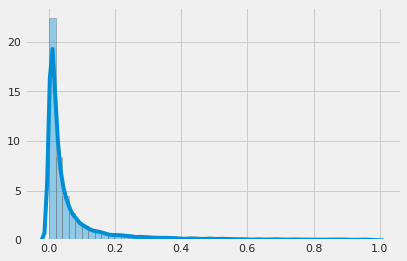

Best Threshold Percentile: 0.24150486827670842
ROC_AUC:  0.8800116738884781
Brier_Score:  0.057499920666819214
Accuracy Score_Test: 0.926
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.65      0.30      0.41      1979

    accuracy                           0.93     22929
   macro avg       0.79      0.64      0.69     22929
weighted avg       0.91      0.93      0.91     22929



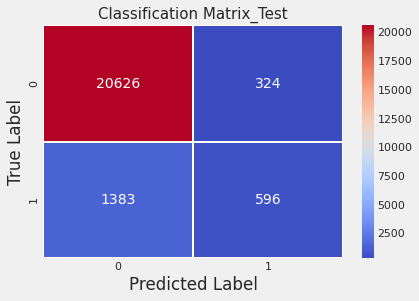

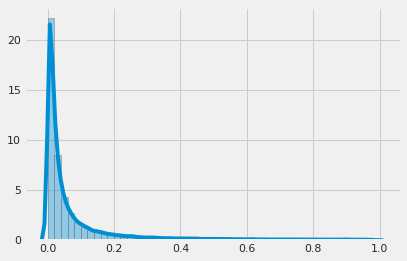

ROC_AUC:  0.894250189607339
Brier_Score:  0.05488908755769946
Accuracy Score_Train: 0.928
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     62848
           1       0.68      0.32      0.44      5936

    accuracy                           0.93     68784
   macro avg       0.81      0.65      0.70     68784
weighted avg       0.92      0.93      0.92     68784



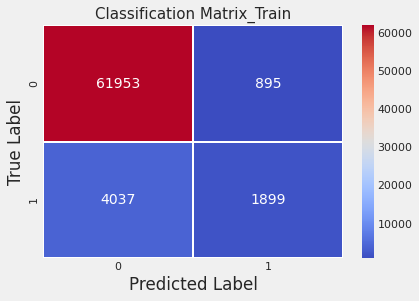

CPU times: user 17.5 s, sys: 3.61 s, total: 21.1 s
Wall time: 6.68 s


In [0]:
%time fit_predict_score(LR, train_processed_data, y_train, test_processed_data, y_test,threshold=0.5)

In [0]:
cols = columns_to_scale+dummies_col
feature_importances =pd.DataFrame(data=abs(LR.coef_.transpose()),index=cols)
feature_importances.rename(columns={0: "Coefficient"},inplace=True)
feature_importances['Importance']=np.round(feature_importances['Coefficient']/feature_importances['Coefficient'].sum()*100,4)
feature_importances.sort_values('Importance',ascending=False,inplace=True)
feature_importances['cumpercent']=feature_importances['Importance'].cumsum()
feature_importances.head(100)

,Coefficient,Importance,cumpercent
apache_3j_bodysystem_Metabolic,1.0,1.5,1.5
bin_d1_lactate_min_100_percentile,1.0,1.5,3.0
elective_surgery_0,0.7,1.0,4.0
bin_d1_heartrate_max_100_percentile,0.7,1.0,4.9
bin_d1_creatinine_max_100_percentile,0.6,0.9,5.9
gcs_motor_apache_2.0,0.6,0.8,6.7
bin_d1_hemaglobin_max_80_percentile,0.6,0.8,7.5
bin_d1_inr_max_100_percentile,0.5,0.8,8.4
age,0.5,0.8,9.1
apache_3j_bodysystem_Neurological,0.5,0.7,9.8


In [0]:
feature_importances[feature_importances.index.isin(['pulse_pressure_min','pulse_pressure_max','diff_pulse_max_min','missing_count','bmi_35_0'])]

,Coefficient,Importance,cumpercent
bmi_35_0,0.2,0.2,70.1
missing_count,0.2,0.2,72.8
pulse_pressure_min,0.1,0.1,91.4
pulse_pressure_max,0.0,0.1,97.0
diff_pulse_max_min,0.0,0.0,99.8


In [0]:
feature_importances.tail(100)

,Coefficient,Importance,cumpercent
"bin_d1_h1_min_glucose_(-638.0, -58.0]",0.0,0.1,96.4
bin_d1_h1_max_arterial_ph_Normal,0.0,0.1,96.5
"bin_d1_h1_max_glucose_(43.0, 522.0]",0.0,0.1,96.5
bin_d1_h1_min_arterial_ph_Normal,0.0,0.1,96.6
gcs_eyes_apache_2.0,0.0,0.1,96.6
arf_apache_0.0,0.0,0.1,96.7
"bin_d1_h1_min_platelets_(-5.0, 0.0]",0.0,0.1,96.8
"bin_d1_h1_max_po2_(-1.0, 13.0]",0.0,0.1,96.8
"bin_fio2_apache_(0.4, 0.5]",0.0,0.1,96.9
"bin_d1_h1_max_pco2_(0.0, 2.0]",0.0,0.1,96.9


In [0]:
len(feature_importances)

459

___
#### Adjust thredold | 90% quantile

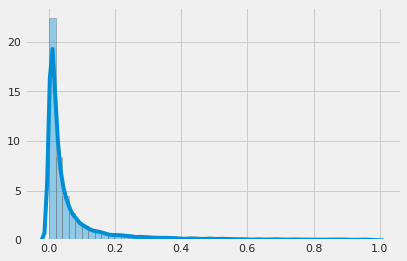

Best Threshold Percentile: 0.24150486827670842
ROC_AUC:  0.8800116738884781
Brier_Score:  0.057499920666819214
Accuracy Score_Test: 0.906
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     20950
           1       0.46      0.54      0.50      1979

    accuracy                           0.91     22929
   macro avg       0.71      0.74      0.72     22929
weighted avg       0.91      0.91      0.91     22929



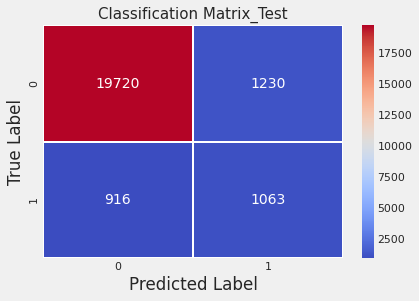

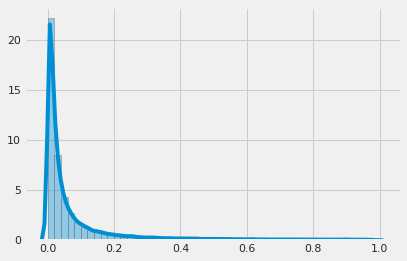

ROC_AUC:  0.894250189607339
Brier_Score:  0.05488908755769946
Accuracy Score_Train: 0.912
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     62848
           1       0.49      0.56      0.52      5936

    accuracy                           0.91     68784
   macro avg       0.72      0.75      0.74     68784
weighted avg       0.92      0.91      0.91     68784



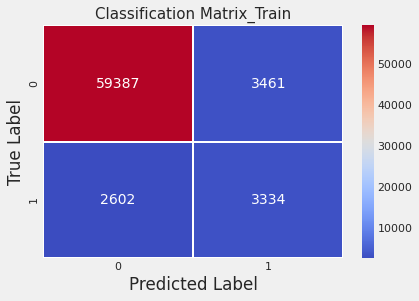

CPU times: user 17.4 s, sys: 3.66 s, total: 21.1 s
Wall time: 6.73 s


In [0]:
%time fit_predict_score(LR, train_processed_data, y_train, test_processed_data, y_test,threshold=0.24150486827670842)

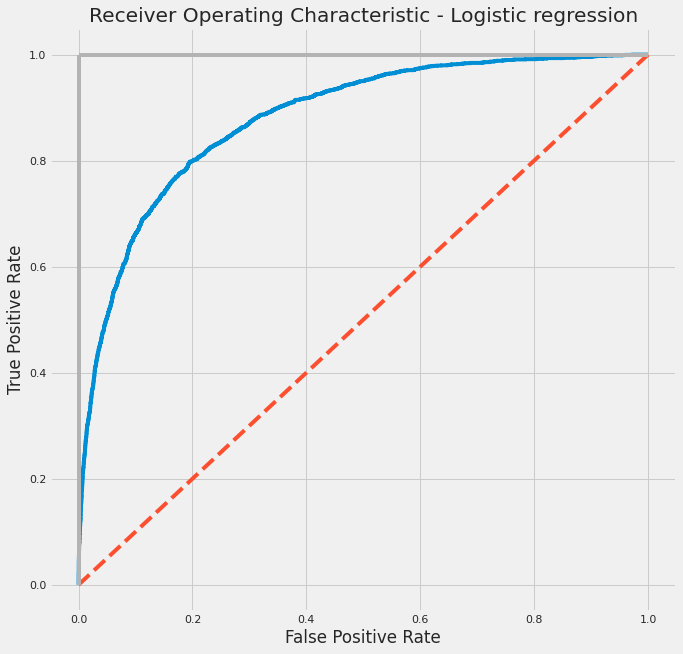

In [0]:
from sklearn.metrics import  roc_curve
plt.figure(figsize=(10,10))
y_score2 = LR.predict_proba(test_processed_data)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)


plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

___
### II.Comparing with icu, hospital death probability

In [0]:
df_death = pd.read_csv('/content/drive/My Drive/Healthcare/Data/training_v2.csv', low_memory = False)
df_death = df_death[['patient_id','apache_4a_icu_death_prob','apache_4a_hospital_death_prob','hospital_death']]
df_death = df_death[df_death.patient_id.isin(test_id)]
df_death.head()

,patient_id,apache_4a_icu_death_prob,apache_4a_hospital_death_prob,hospital_death
3,46918,0.0,0.0,0
5,74489,0.0,0.1,0
9,90749,0.0,0.0,0
12,41311,0.0,0.0,0
17,112115,0.1,0.1,0


In [0]:
df_death.fillna(0,inplace=True)
df_death.loc[df_death['apache_4a_hospital_death_prob']<0,'apache_4a_hospital_death_prob']=0
df_death.loc[df_death['apache_4a_icu_death_prob']<0,'apache_4a_icu_death_prob']=0

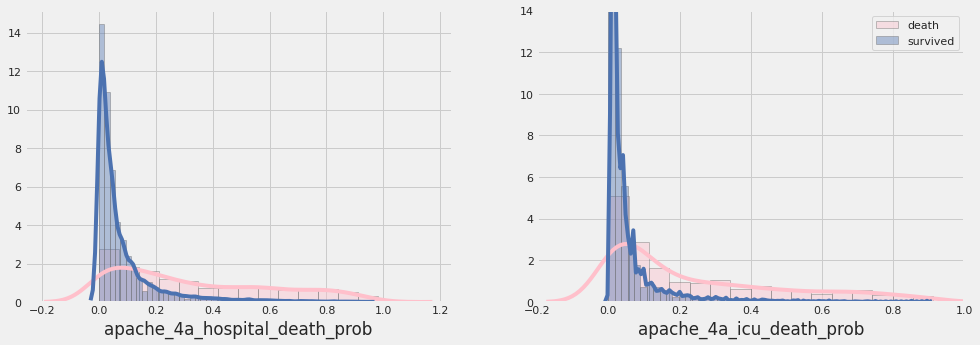

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df_death[df_death['hospital_death']==1].apache_4a_hospital_death_prob, hist=True, kde=True, ax = ax[0], color ='pink',  label='death')
sns.distplot(df_death[df_death['hospital_death']==0].apache_4a_hospital_death_prob, hist=True, kde=True, ax = ax[0], color='b',  label='survived')
plt.xlim(-0.2,1)
plt.ylim(0,14)
sns.distplot(df_death[df_death['hospital_death']==1].apache_4a_icu_death_prob, hist=True, kde=True,ax = ax[1],color ='pink',  label='death')
sns.distplot(df_death[df_death['hospital_death']==0].apache_4a_icu_death_prob, hist=True, kde=True,ax = ax[1], color='b',  label='survived')
plt.xlim(-0.2,1)
plt.ylim(0,14)
plt.legend();

In [0]:
lr_df =pd.DataFrame({'Test_Probability':LR.predict_proba(test_processed_data)[:,1],'y_test':y_test})

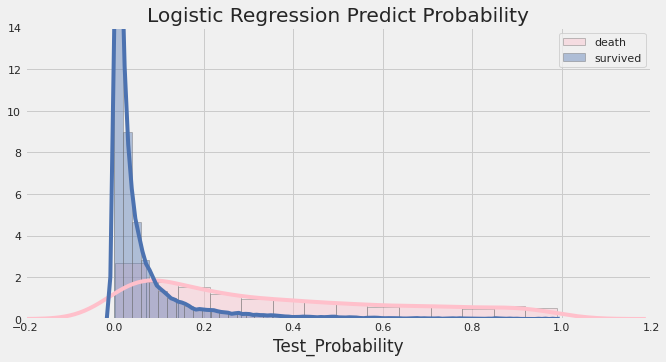

In [0]:
plt.figure(figsize=(10, 5))
sns.distplot(lr_df[lr_df['y_test']==1].Test_Probability, hist=True, kde=True, color ='pink',  label='death')
sns.distplot(lr_df[lr_df['y_test']==0].Test_Probability, hist=True, kde=True, color='b',  label='survived')
plt.legend()
plt.xlim(-0.2,1.2)
plt.ylim(0,14)
plt.title('Logistic Regression Predict Probability')
plt.show()

In [0]:
df_death['apache_4a_hospital_death_prob'].values
df_death['apache_4a_hospital_death_prob'].isnull().sum()

0

In [0]:
df_death.fillna(0,inplace=True)
df_death.loc[df_death['apache_4a_hospital_death_prob']<0,'apache_4a_hospital_death_prob']=0


In [0]:
hospital_death =df_death['hospital_death'].values

In [0]:
apache_4a_icu_death_prob= df_death['apache_4a_hospital_death_prob'].values
print('ROC_AUC: ',roc_auc_score(hospital_death,y_score=apache_4a_icu_death_prob))

ROC_AUC:  0.7943673367494734


In [0]:
print('Brier_Score: ',brier_score_loss(hospital_death,apache_4a_icu_death_prob))

Brier_Score:  0.06561165772602381


In [0]:
'ROC_AUC: ',roc_auc_score(hospital_death,y_score=y_pred_test)

In [0]:
apache_4a_icu_death_prob= df_death['apache_4a_icu_death_prob'].values
for i in range(0,len(apache_4a_icu_death_prob)):
  if apache_4a_icu_death_prob[i]>= 0.5:
    apache_4a_icu_death_prob[i]=1
  else:
    apache_4a_icu_death_prob[i]=0

In [0]:
apache_4a_hospital_death_prob= df_death['apache_4a_hospital_death_prob'].values
for i in range(0,len(apache_4a_hospital_death_prob)):
  if apache_4a_hospital_death_prob[i]>= 0.5:
    apache_4a_hospital_death_prob[i]=1
  else:
    apache_4a_hospital_death_prob[i]=0

In [0]:
hospital_death =df_death['hospital_death'].values

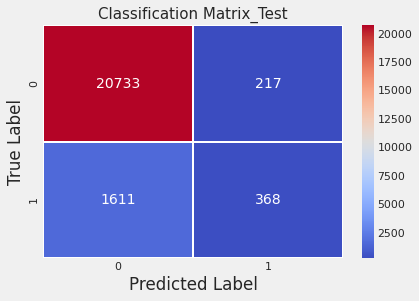

In [0]:
df_label_names = [0,1]
confusion_matrix_test =  metrics.confusion_matrix(hospital_death, apache_4a_icu_death_prob)
sns.heatmap(confusion_matrix_test, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=df_label_names, yticklabels=df_label_names, annot=True, fmt='d')
plt.title("Classification Matrix_Test", fontsize = 15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

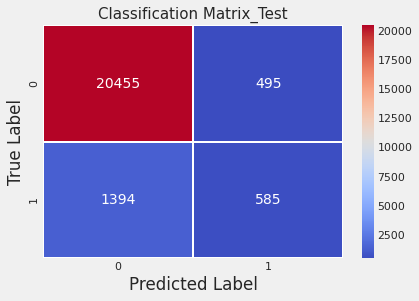

In [0]:
df_label_names = [0,1]
confusion_matrix_test =  metrics.confusion_matrix(hospital_death, apache_4a_hospital_death_prob)
sns.heatmap(confusion_matrix_test, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=df_label_names, yticklabels=df_label_names, annot=True, fmt='d')
plt.title("Classification Matrix_Test", fontsize = 15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [0]:
print(classification_report(hospital_death, apache_4a_icu_death_prob))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     20950
           1       0.63      0.19      0.29      1979

    accuracy                           0.92     22929
   macro avg       0.78      0.59      0.62     22929
weighted avg       0.90      0.92      0.90     22929



In [0]:
print(classification_report(hospital_death, apache_4a_hospital_death_prob))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     20950
           1       0.54      0.30      0.38      1979

    accuracy                           0.92     22929
   macro avg       0.74      0.64      0.67     22929
weighted avg       0.90      0.92      0.91     22929



In [0]:
apache_4a_icu_death_prob1= df_death['apache_4a_icu_death_prob'].values
for i in range(0,len(apache_4a_icu_death_prob1)):
  if apache_4a_icu_death_prob1[i]>=0.24150486827670842:
    apache_4a_icu_death_prob1[i]=1
  else:
    apache_4a_icu_death_prob1[i]=0

In [0]:
sum(df_death['apache_4a_icu_death_prob'].values)

1575.0

In [0]:
print(classification_report(hospital_death, apache_4a_icu_death_prob1))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     20950
           1       0.47      0.38      0.42      1979

    accuracy                           0.91     22929
   macro avg       0.71      0.67      0.69     22929
weighted avg       0.90      0.91      0.91     22929



In [0]:
apache_4a_hospital_death_prob1= df_death['apache_4a_hospital_death_prob'].values
for i in range(0,len(apache_4a_hospital_death_prob1)):
  if apache_4a_hospital_death_prob1[i]>= 0.24150486827670842:
    apache_4a_hospital_death_prob1[i]=1
  else:
    apache_4a_hospital_death_prob1[i]=0

In [0]:
print(classification_report(hospital_death, apache_4a_hospital_death_prob1))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     20950
           1       0.36      0.52      0.43      1979

    accuracy                           0.88     22929
   macro avg       0.66      0.72      0.68     22929
weighted avg       0.90      0.88      0.89     22929



___
### III.Random Forest

#### 1.Baseline

In [0]:
rfc = RandomForestClassifier(n_estimators=100,bootstrap='True',max_depth=6,max_features=400,max_leaf_nodes=10,min_samples_leaf=10,min_samples_split=10,random_state=233)

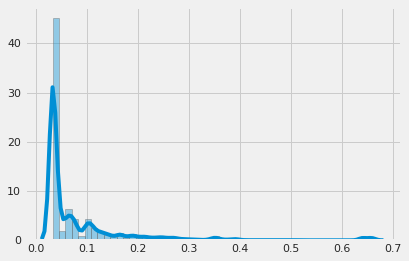

Best Threshold Percentile: 0.19317779615245198
ROC_AUC:  0.8189674035607772
Brier_Score:  0.0646125968145405
Accuracy Score_Test: 0.919
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     20950
           1       0.66      0.14      0.22      1979

    accuracy                           0.92     22929
   macro avg       0.79      0.56      0.59     22929
weighted avg       0.90      0.92      0.89     22929



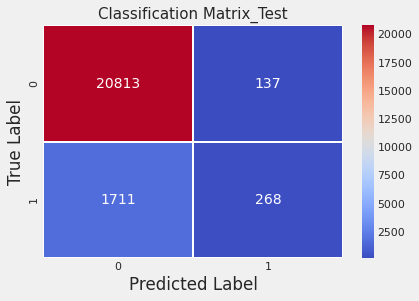

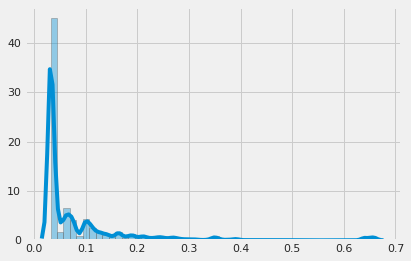

ROC_AUC:  0.8226593103186364
Brier_Score:  0.06446996238169025
Accuracy Score_Train: 0.92
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     62848
           1       0.67      0.14      0.24      5936

    accuracy                           0.92     68784
   macro avg       0.80      0.57      0.60     68784
weighted avg       0.90      0.92      0.90     68784



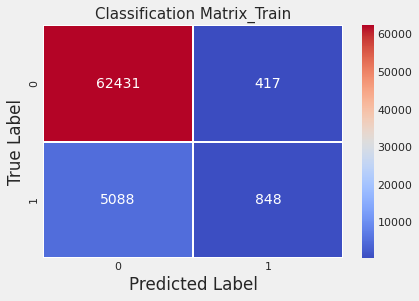

In [0]:
fit_predict_score(rfc, train_processed_data, y_train, test_processed_data, y_test,threshold=0.5)

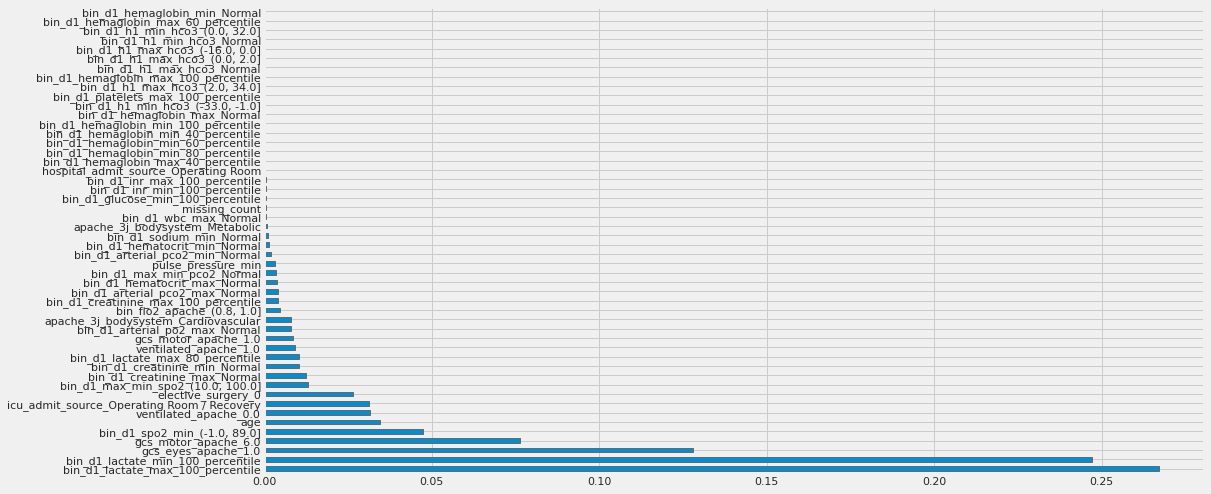

In [0]:
cols = columns_to_scale+dummies_col
fig, ax = plt.subplots(figsize=(15,8))
feat_importances = pd.Series(rfc.feature_importances_, index=cols).sort_values(ascending=False)[:50]
feat_importances.nlargest(125).plot(kind='barh')
plt.show()

In [0]:
rfc_importance =pd.DataFrame(rfc.feature_importances_, index=cols,columns=['Importance']).sort_values('Importance',ascending =False)
rfc_importance['cumsum']= rfc_importance.Importance.cumsum()/rfc_importance.Importance.sum()*100
rfc_importance

,Importance,cumsum
bin_d1_lactate_max_100_percentile,0.3,26.7
bin_d1_lactate_min_100_percentile,0.2,51.4
gcs_eyes_apache_1.0,0.1,64.2
gcs_motor_apache_6.0,0.1,71.9
"bin_d1_spo2_min_(-1.0, 89.0]",0.0,76.6
age,0.0,80.1
ventilated_apache_0.0,0.0,83.2
icu_admit_source_Operating Room / Recovery,0.0,86.3
elective_surgery_0,0.0,89.0
"bin_d1_max_min_spo2_(10.0, 100.0]",0.0,90.3


In [0]:
rfc_importance[rfc_importance['cumsum'] < 99.9].index.to_list()

['bin_d1_lactate_max_100_percentile',
 'bin_d1_lactate_min_100_percentile',
 'gcs_eyes_apache_1.0',
 'gcs_motor_apache_6.0',
 'bin_d1_spo2_min_(-1.0, 89.0]',
 'age',
 'ventilated_apache_0.0',
 'icu_admit_source_Operating Room / Recovery',
 'elective_surgery_0',
 'bin_d1_max_min_spo2_(10.0, 100.0]',
 'bin_d1_creatinine_max_Normal',
 'bin_d1_creatinine_min_Normal',
 'bin_d1_lactate_max_80_percentile',
 'ventilated_apache_1.0',
 'gcs_motor_apache_1.0',
 'bin_d1_arterial_po2_max_Normal',
 'apache_3j_bodysystem_Cardiovascular',
 'bin_fio2_apache_(0.8, 1.0]',
 'bin_d1_creatinine_max_100_percentile',
 'bin_d1_arterial_pco2_max_Normal',
 'bin_d1_hematocrit_max_Normal',
 'bin_d1_max_min_pco2_Normal',
 'pulse_pressure_min',
 'bin_d1_arterial_pco2_min_Normal',
 'bin_d1_hematocrit_min_Normal',
 'bin_d1_sodium_min_Normal',
 'apache_3j_bodysystem_Metabolic',
 'bin_d1_wbc_max_Normal',
 'missing_count']

#### 2.keep 99% of importance

In [0]:
subset=rfc_importance[rfc_importance['cumsum'] < 99.9].index.to_list()
subset.append('hospital_death')
len(subset)

30

In [0]:
df_model_rfc=df_model[subset]
df_model_rfc.head()

,bin_d1_lactate_max_100_percentile,bin_d1_lactate_min_100_percentile,gcs_eyes_apache_1.0,gcs_motor_apache_6.0,"bin_d1_spo2_min_(-1.0, 89.0]",age,ventilated_apache_0.0,icu_admit_source_Operating Room / Recovery,elective_surgery_0,"bin_d1_max_min_spo2_(10.0, 100.0]",bin_d1_creatinine_max_Normal,bin_d1_creatinine_min_Normal,bin_d1_lactate_max_80_percentile,ventilated_apache_1.0,gcs_motor_apache_1.0,bin_d1_arterial_po2_max_Normal,apache_3j_bodysystem_Cardiovascular,"bin_fio2_apache_(0.8, 1.0]",bin_d1_creatinine_max_100_percentile,bin_d1_arterial_pco2_max_Normal,bin_d1_hematocrit_max_Normal,bin_d1_max_min_pco2_Normal,pulse_pressure_min,bin_d1_arterial_pco2_min_Normal,bin_d1_hematocrit_min_Normal,bin_d1_sodium_min_Normal,apache_3j_bodysystem_Metabolic,bin_d1_wbc_max_Normal,missing_count,hospital_death
0,0,0,0,1,1,68.0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,1,36.0,1,0,0,0,0,60,0
1,0,1,1,0,1,77.0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,36.0,0,0,0,0,0,11,0
2,0,0,0,1,0,25.0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,1,1,57.0,1,1,1,1,1,96,0
3,0,0,0,1,0,81.0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,42.0,0,0,1,0,0,48,0
4,0,0,0,0,0,19.0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,1,1,63.0,1,1,1,0,1,104,0


In [0]:
subset

['bin_d1_lactate_max_100_percentile',
 'bin_d1_lactate_min_100_percentile',
 'gcs_eyes_apache_1.0',
 'gcs_motor_apache_6.0',
 'bin_d1_spo2_min_(-1.0, 89.0]',
 'age',
 'ventilated_apache_0.0',
 'icu_admit_source_Operating Room / Recovery',
 'elective_surgery_0',
 'bin_d1_max_min_spo2_(10.0, 100.0]',
 'bin_d1_creatinine_max_Normal',
 'bin_d1_creatinine_min_Normal',
 'bin_d1_lactate_max_80_percentile',
 'ventilated_apache_1.0',
 'gcs_motor_apache_1.0',
 'bin_d1_arterial_po2_max_Normal',
 'apache_3j_bodysystem_Cardiovascular',
 'bin_fio2_apache_(0.8, 1.0]',
 'bin_d1_creatinine_max_100_percentile',
 'bin_d1_arterial_pco2_max_Normal',
 'bin_d1_hematocrit_max_Normal',
 'bin_d1_max_min_pco2_Normal',
 'pulse_pressure_min',
 'bin_d1_arterial_pco2_min_Normal',
 'bin_d1_hematocrit_min_Normal',
 'bin_d1_sodium_min_Normal',
 'apache_3j_bodysystem_Metabolic',
 'bin_d1_wbc_max_Normal',
 'missing_count',
 'hospital_death']

In [0]:
dummies_col_sub_rfc =['bin_d1_lactate_max_100_percentile',
 'bin_d1_lactate_min_100_percentile',
 'gcs_eyes_apache_1.0',
 'gcs_motor_apache_6.0',
 'bin_d1_spo2_min_(-1.0, 89.0]',
 'ventilated_apache_0.0',
 'icu_admit_source_Operating Room / Recovery',
 'elective_surgery_0',
 'bin_d1_max_min_spo2_(10.0, 100.0]',
 'bin_d1_creatinine_max_Normal',
 'bin_d1_creatinine_min_Normal',
 'bin_d1_lactate_max_80_percentile',
 'ventilated_apache_1.0',
 'gcs_motor_apache_1.0',
 'bin_d1_arterial_po2_max_Normal',
 'apache_3j_bodysystem_Cardiovascular',
 'bin_fio2_apache_(0.8, 1.0]',
 'bin_d1_creatinine_max_100_percentile',
 'bin_d1_arterial_pco2_max_Normal',
 'bin_d1_hematocrit_max_Normal',
 'bin_d1_max_min_pco2_Normal',
 'pulse_pressure_min',
 'bin_d1_arterial_pco2_min_Normal',
 'bin_d1_hematocrit_min_Normal',
 'bin_d1_sodium_min_Normal',
 'apache_3j_bodysystem_Metabolic',
 'bin_d1_wbc_max_Normal',]
columns_continuous_rfc =['age', 'missing_count']

In [0]:
train_processed_data_rfc,test_processed_data_rfc,y_train,y_test=split_normalize(df_model_rfc,dummies_col_sub_rfc,columns_continuous_rfc)

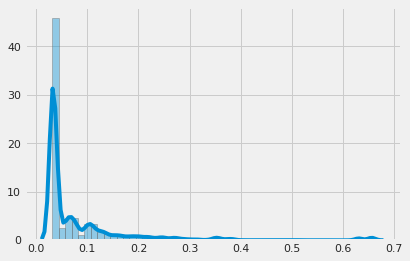

Best Threshold Percentile: 0.19438209850406196
ROC_AUC:  0.8200248311326204
Brier_Score:  0.06457469856000088
Accuracy Score_Test: 0.912
Classification Report_Test:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     20950
           1       0.49      0.35      0.41      1979

    accuracy                           0.91     22929
   macro avg       0.72      0.66      0.68     22929
weighted avg       0.90      0.91      0.91     22929



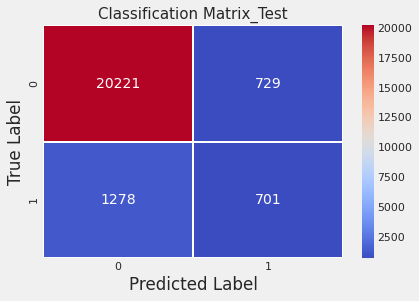

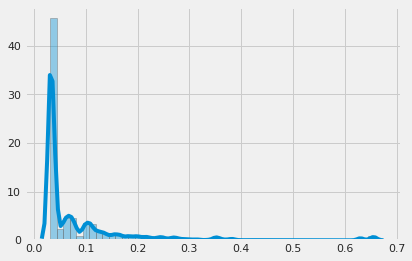

ROC_AUC:  0.8239534281208485
Brier_Score:  0.06443076209914936
Accuracy Score_Train: 0.912
Classification Report_Train:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     62848
           1       0.49      0.35      0.41      5936

    accuracy                           0.91     68784
   macro avg       0.71      0.66      0.68     68784
weighted avg       0.90      0.91      0.91     68784



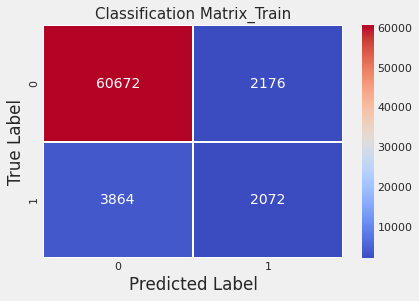

CPU times: user 8.39 s, sys: 35.1 ms, total: 8.43 s
Wall time: 8.43 s


In [0]:
rfc = RandomForestClassifier(n_estimators=100,bootstrap='True',max_depth=6,max_features=25,max_leaf_nodes=10,min_samples_leaf=10,min_samples_split=10,random_state=233)
%time fit_predict_score(rfc,train_processed_data_rfc,y_train,test_processed_data_rfc,y_test,0.25)

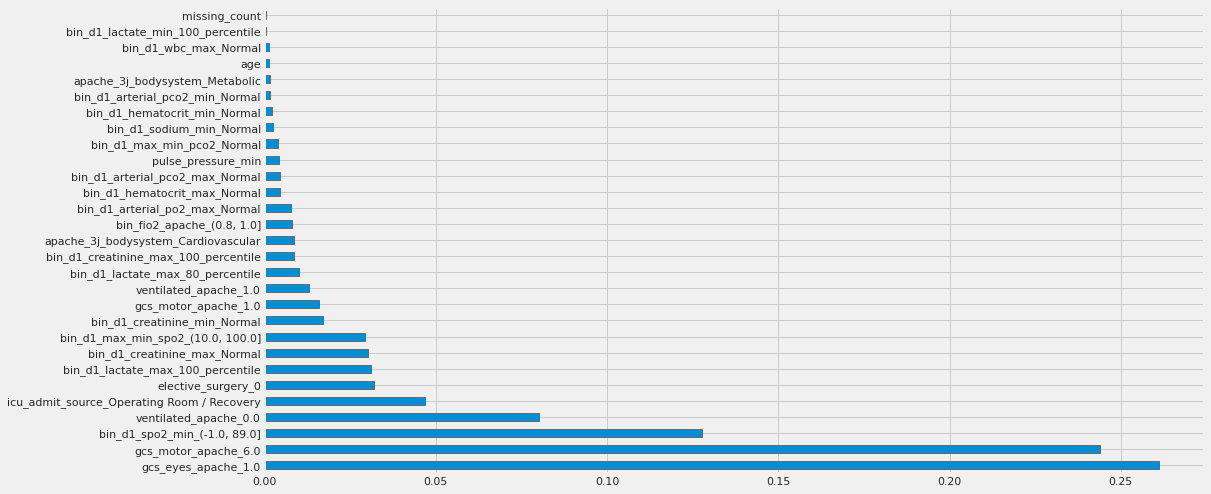

In [0]:
cols = dummies_col_sub_rfc+columns_continuous_rfc
fig, ax = plt.subplots(figsize=(15,8))
feat_importances = pd.Series(rfc.feature_importances_, index=cols).sort_values(ascending=False)[:50]
feat_importances.nlargest(125).plot(kind='barh')
plt.show()

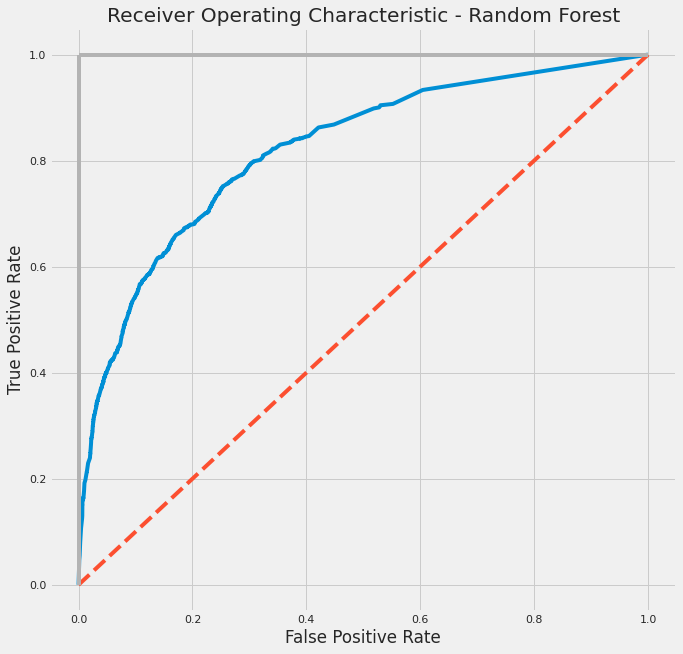

In [0]:
plt.figure(figsize=(10,10))
y_score2 = rfc.predict_proba(test_processed_data_rfc)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)


plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
#cols = columns_to_scale+dummies_col
rfc_importance = pd.DataFrame(rfc.feature_importances_, index=cols,columns=['Importance']).sort_values('Importance',ascending =False)
rfc_importance['cumsum']= rfc_importance.Importance.cumsum()/rfc_importance.Importance.sum()

In [0]:
pd.set_option('display.float_format', '{:20,.2f}'.format)
rfc_importance.drop('cumsum',axis=1)

,Importance
gcs_eyes_apache_1.0,0.26
gcs_motor_apache_6.0,0.24
"bin_d1_spo2_min_(-1.0, 89.0]",0.13
ventilated_apache_0.0,0.08
icu_admit_source_Operating Room / Recovery,0.05
elective_surgery_0,0.03
bin_d1_lactate_max_100_percentile,0.03
bin_d1_creatinine_max_Normal,0.03
"bin_d1_max_min_spo2_(10.0, 100.0]",0.03
bin_d1_creatinine_min_Normal,0.02
